# Preprocessing

### Importing libraries and datasets

In [30]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import functions as cf 

from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae, r2_score
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm


In [31]:
combined_file_path = '../data/cleaned/winequality_combined_cleaned.csv' 
red_file_path = '../data/cleaned/winequality_red_cleaned.csv'
white_file_path = '../data/cleaned/winequality_white_cleaned.csv'
combined_df = pd.read_csv(combined_file_path)
red_df = pd.read_csv(red_file_path, index_col=0)
white_df = pd.read_csv(white_file_path, index_col=0)
red_df

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.660,0.00,1.8,0.075,13.0,40.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1354,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.99651,3.42,0.82,9.5,6
1355,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1356,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1357,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


Wine acidity in g/l:
6.2

Residual sugar (approx.) in g/l:
12.4

Alcohol % ABV:
9.5


In [32]:
#Identification of 
alcohol_filtered_df = white_df[white_df['alcohol'] == 9.5]
sugar_filtered_df = alcohol_filtered_df[alcohol_filtered_df['residual_sugar'] == 12.4]
acidity_filtered_df = sugar_filtered_df[sugar_filtered_df['fixed_acidity'] == 6.2]
print(acidity_filtered_df)

      fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
3131            6.2              0.22          0.3            12.4      0.054   

      free_sulfur_dioxide  total_sulfur_dioxide  density   pH  sulphates  \
3131                108.0                 152.0  0.99728  3.1       0.47   

      alcohol  quality  
3131      9.5        6  


In [33]:
def linear_regression(X_train, X_test, y_train, y_test):
    # Linear regression
    lm = LinearRegression()
    model = lm.fit(X_train, y_train)
    print(f'model coefficients:\n {model.coef_}\n')
    print(f'model intercept:\n {model.intercept_}\n')
    
    # Applying model to X test
    y_pred = model.predict(X_test)
    
    # Ensure y_test is in the correct format (pandas Series or 1D numpy array)
    if isinstance(y_test, pd.Series):
        y_test_reset = y_test.reset_index(drop=True)
    else:
        y_test_reset = y_test  # Assuming y_test is already a numpy array
    
    # Creating combined table with y_test and y_pred
    # Check if y_test_reset is a pandas Series and convert y_pred to a similar type
    if isinstance(y_test_reset, pd.Series):
        y_pred_series = pd.Series(y_pred, index=y_test_reset.index, name='y_pred')
        residuals_df = pd.concat([y_test_reset, y_pred_series], axis=1)
    else:
        # If inputs are numpy arrays, stack them horizontally
        residuals_df = np.column_stack((y_test_reset, y_pred))
        # Convert to DataFrame for easier manipulation later on
        residuals_df = pd.DataFrame(residuals_df, columns=["y_test", "y_pred"])
    
    # Calculating residuals
    residuals_df["residual"] = residuals_df["y_test"] - residuals_df["y_pred"]
    print(f'Residuals:\n {residuals_df}\n')

    # Root mean squared error
    rmse = mse(y_test_reset, residuals_df["y_pred"], squared=False)
    print(f'Root mean squared error: {rmse} \n')

    # R^2
    r2 = r2_score(y_test_reset, residuals_df["y_pred"])
    print(f'R2: {r2} \n')

    # Calculating adjusted R^2
    n = X_train.shape[0]  # Number of observations in the training set
    p = X_train.shape[1]  # Number of features used for training
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    print(f'Adjusted R2: {adjusted_r2} \n')

    return model.coef_


import pandas as pd
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score



def evaluate_model_performance(y_test, y_pred, X_train):
    """
    Evaluates the performance of a regression model by calculating and printing
    the ME, MAE, MSE, RMSE, R^2, and adjusted R^2.

    Parameters:
    - y_test: pandas Series or DataFrame, actual target values.
    - y_pred: array-like or pandas Series, predicted target values.
    - X_train: pandas DataFrame, feature set used for training the model.

    Returns:
    - Prints the ME, MAE, MSE, RMSE, R^2, and adjusted R^2 of the model.
    """
    # Ensure y_pred is a DataFrame with appropriate column name
    if not isinstance(y_pred, pd.DataFrame):
        y_pred = pd.DataFrame(y_pred, columns=["y_pred"])
    else:
        y_pred = y_pred.rename(columns={y_pred.columns[0]: "y_pred"})

    # Reset index and rename y_test for consistency
    if isinstance(y_test, pd.Series):
        y_test = y_test.reset_index(drop=True).rename("y_test")
    elif isinstance(y_test, pd.DataFrame):
        y_test = y_test.reset_index(drop=True)
        y_test.columns = ["y_test"]

    # Concatenate actual and predicted values and calculate residuals
    residuals_df = pd.concat([y_test, y_pred], axis=1)
    residuals_df["residual"] = residuals_df["y_test"] - residuals_df["y_pred"]

    # Calculate Mean Error (ME)
    me = residuals_df["residual"].mean()
    print(f'Mean Error (ME): {me:.4f}')

    # Calculate Mean Absolute Error (MAE)
    mae_value = mae(residuals_df["y_test"], residuals_df["y_pred"])
    print(f'Mean Absolute Error (MAE): {mae_value:.4f}')

    # Calculate Mean Squared Error (MSE)
    mse_value = mse(residuals_df["y_test"], residuals_df["y_pred"])
    print(f'Mean Squared Error (MSE): {mse_value:.4f}')

    # Calculate Root Mean Squared Error (RMSE)
    rmse = mse(residuals_df["y_test"], residuals_df["y_pred"], squared=False)
    print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')

    # Calculate R^2
    r2 = r2_score(residuals_df["y_test"], residuals_df["y_pred"])
    print(f'R²: {r2:.4f}')

    # Calculate Adjusted R^2
    n = X_train.shape[0]  # Number of observations
    p = X_train.shape[1]  # Number of features
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    print(f'Adjusted R²: {adjusted_r2:.4f}')



## Correlations

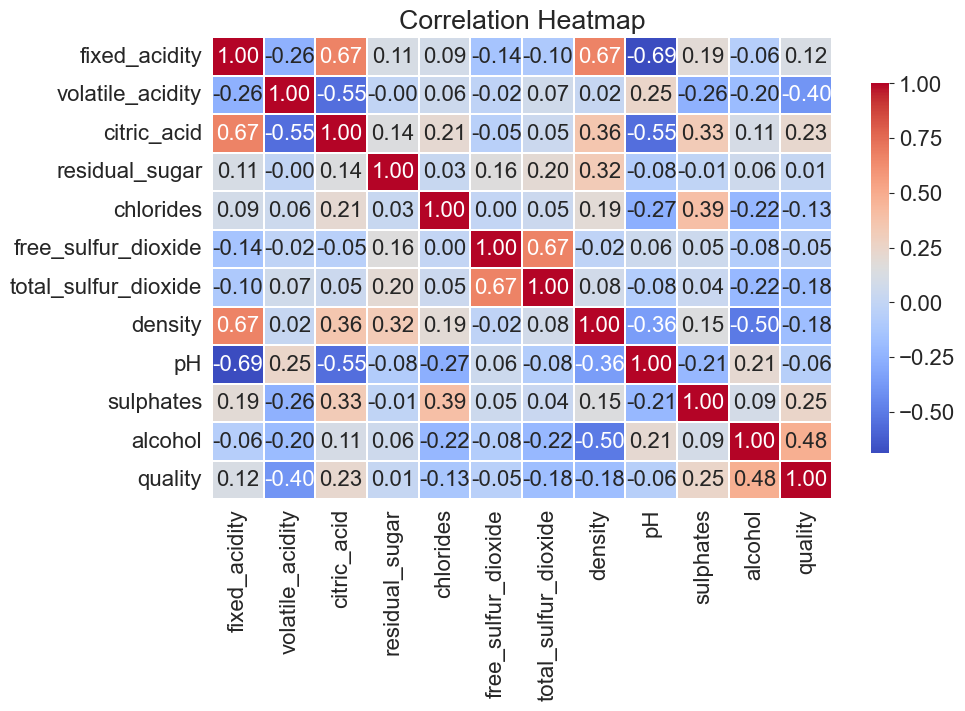

In [34]:
#Red_wine
corr_matrix_red = red_df.corr()
plt.figure(figsize=(10, 6)) 
sns.heatmap(corr_matrix_red, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.05, cbar_kws={'shrink': .8})
plt.title('Correlation Heatmap')  
plt.show()


## IQR Method to handle Outliers

In [35]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.25)
    quartile3 = dataframe[variable].quantile(0.75)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = round(low_limit,5)
    dataframe.loc[(dataframe[variable] > up_limit), variable] = round(up_limit,5)
    


In [36]:
red_df.columns

Index(['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

In [37]:
columns_gpt = ['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'sulphates']# only columns identified as having outliers

columns_matthew = ['citric_acid', 'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'pH', 'sulphates']

columns_combined = ['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'pH', 'sulphates']

columns_all = ['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'pH', 'sulphates', 'alcohol']

In [38]:
#for col in columns_matthew:
   # replace_with_thresholds(red_df, col)

In [39]:
print(red_df.head())

   fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.66         0.00             1.8      0.075   

   free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 13.0                  40.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5 

### Distributions

<Figure size 1500x1500 with 0 Axes>

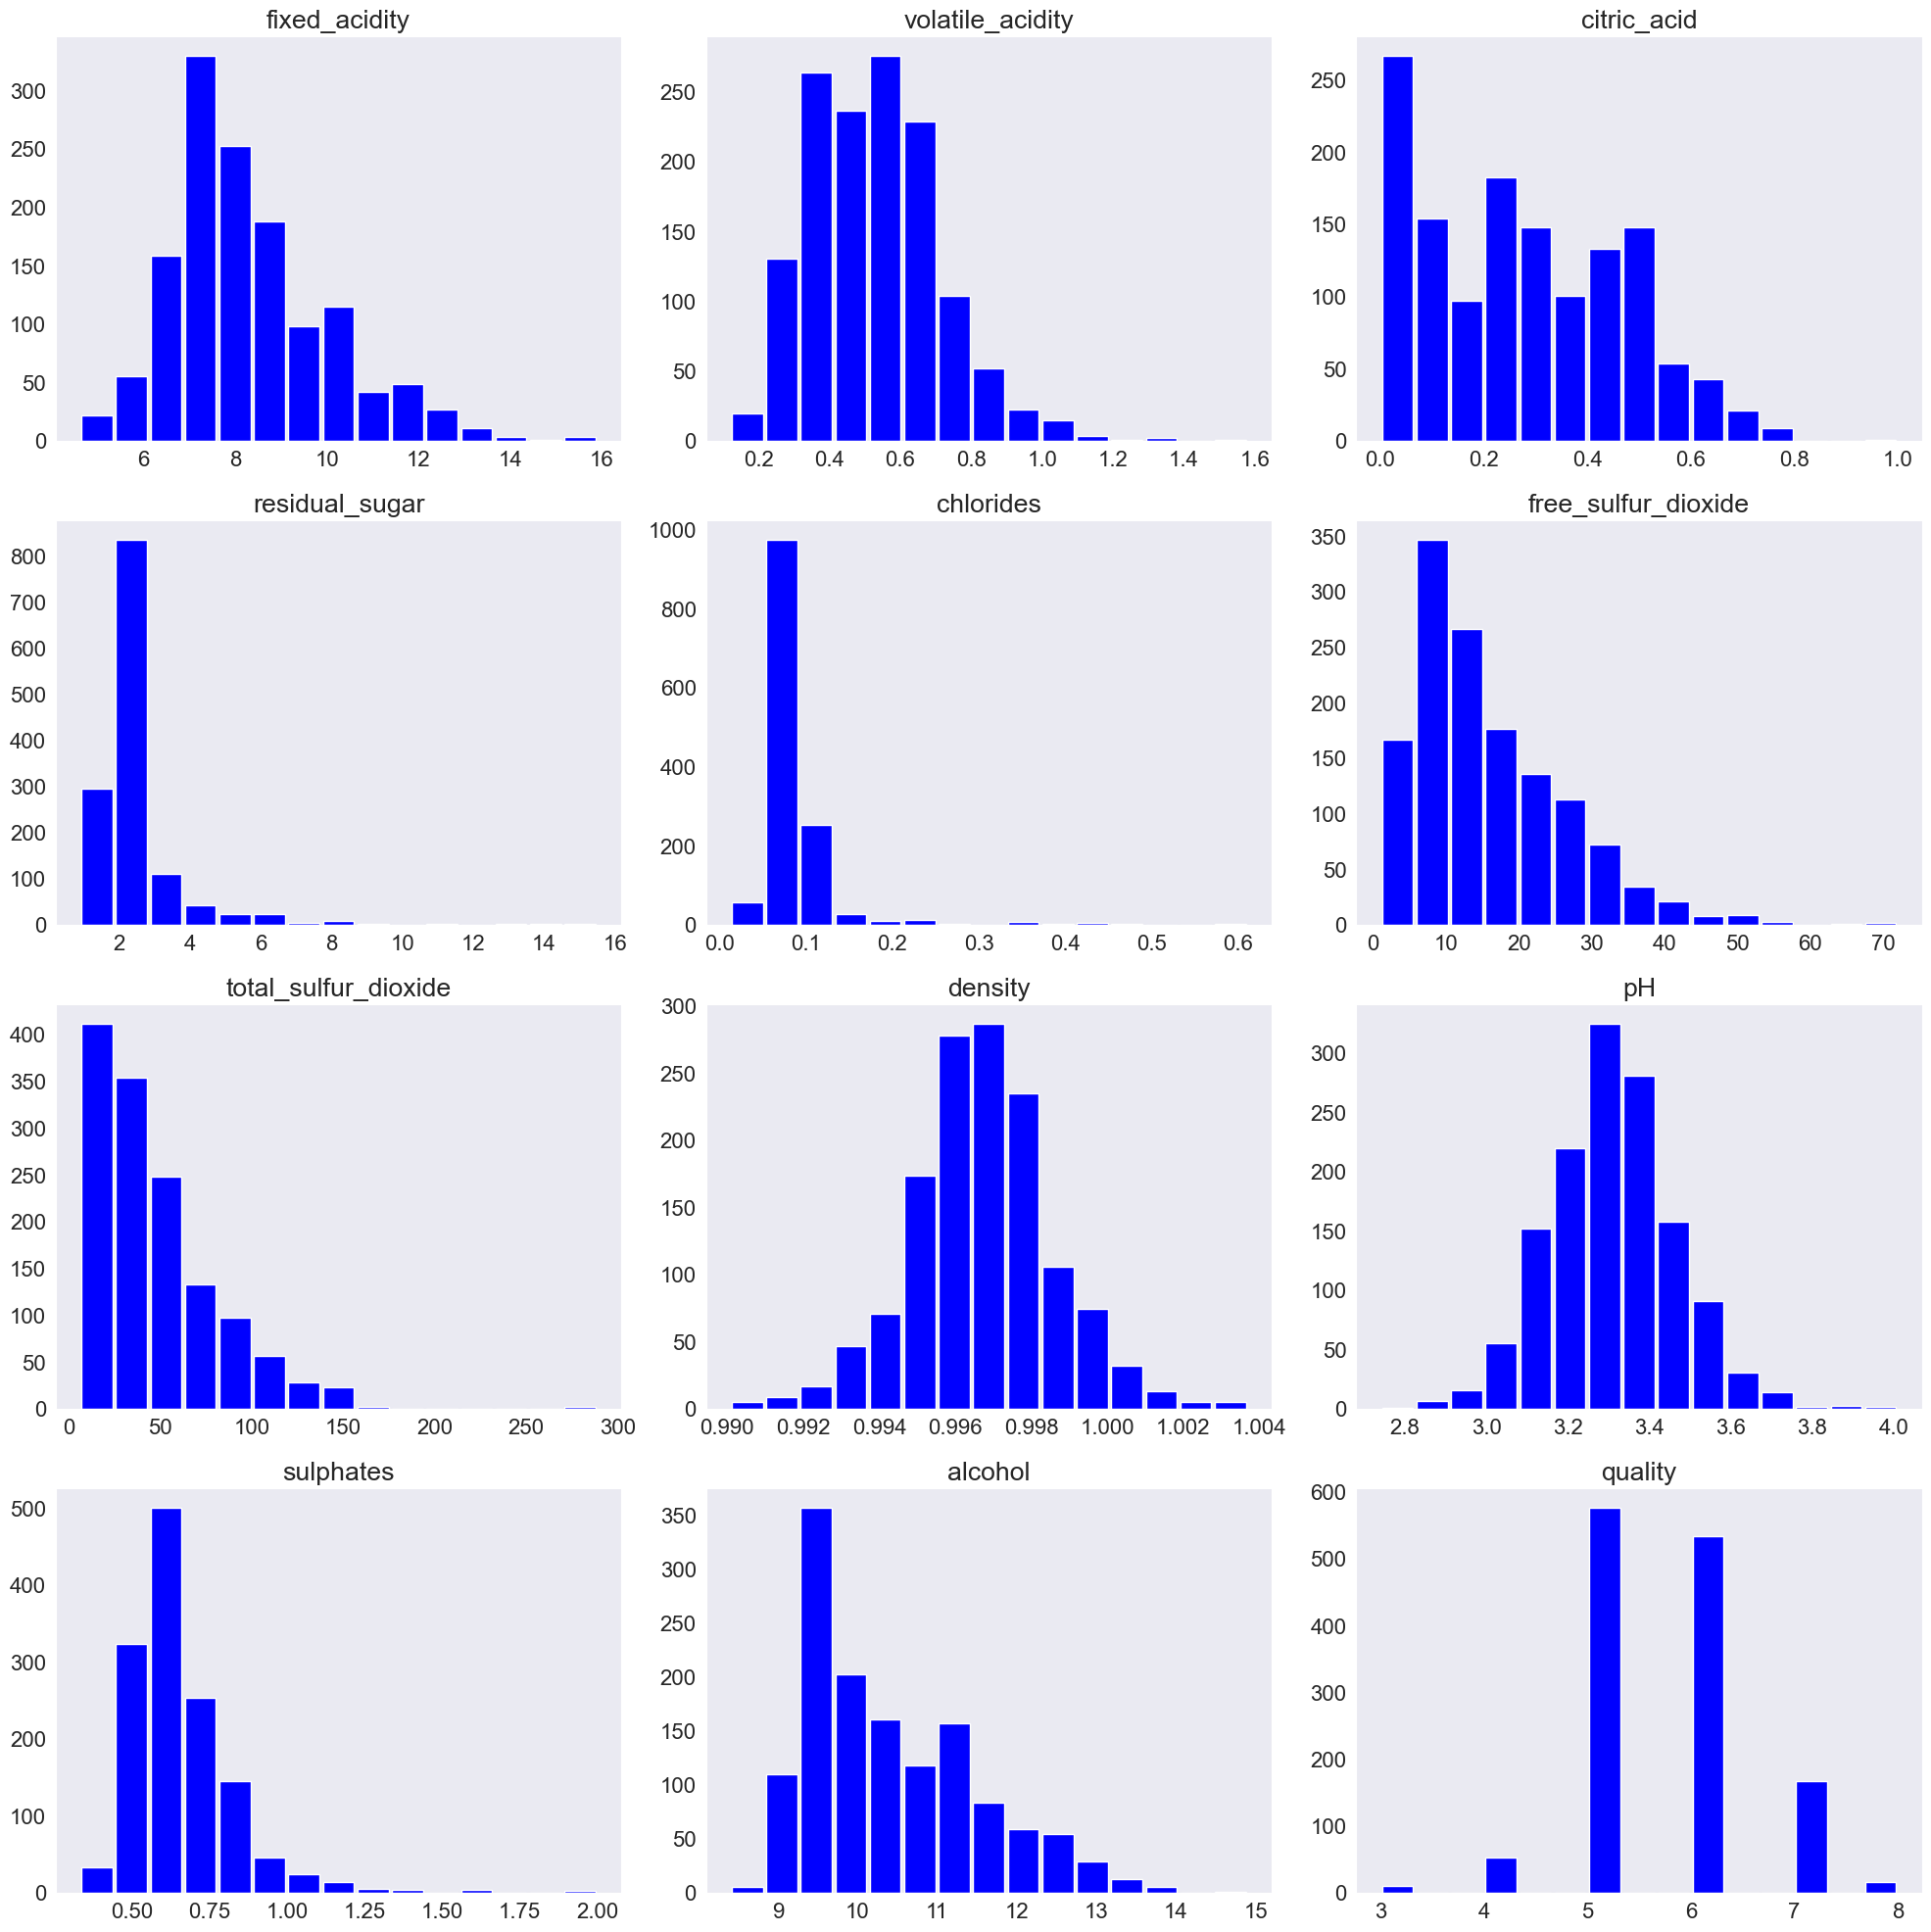

In [40]:
plt.figure(figsize=(15, 15))
red_df.hist(bins=15, grid=False, figsize=(20, 20), color='blue', zorder=2, rwidth=0.9)
plt.tight_layout()
plt.rcParams.update({'font.size': 16})
plt.show()

### Splitting data into X and y

#### Red Wine

In [41]:
X = red_df.drop(['quality', 'free_sulfur_dioxide'], axis=1)
#X = pd.DataFrame(red_df[['citric_acid', 'total_sulfur_dioxide', 'density', 'pH', 'residual_sugar', 'chlorides', 'sulphates', 'alcohol']])
y = pd.DataFrame(red_df["quality"])

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42)

#### White Wine

## Applying Scalers and Transforms

### PowerTransformer on X

In [42]:
pt = PowerTransformer(method='yeo-johnson')
pt.fit(X_train)
X_train_p = pd.DataFrame(pt.transform(X_train))
X_test_p= pd.DataFrame(pt.transform(X_test))


### PowerTransformer on y

In [43]:
pt_y = PowerTransformer(method='yeo-johnson')
pt_y.fit(y_train)
y_train_p = pt_y.transform(y_train)
y_test_p = pt_y.transform(y_test)


### MinMax Scaler on X

In [44]:
scaler_mm_x = MinMaxScaler()
scaler_mm_x.fit(X_train)
X_train_mm = scaler_mm_x.transform(X_train)
X_test_mm = scaler_mm_x.transform(X_test)

### MinMax Scaler on y

In [45]:
scaler_mm_y = MinMaxScaler()
scaler_mm_y.fit(y_train)
y_train_mm = scaler_mm_y.transform(y_train)
y_test_mm = scaler_mm_y.transform(y_test)

### Standard Scaler on X

In [46]:
scaler_s_x = StandardScaler()
scaler_s_x.fit(X_train)
X_train_s = scaler_s_x.transform(X_train)
X_test_s = scaler_s_x.transform(X_test)

### Standard Scaler on y

In [47]:
scaler_s_y = StandardScaler()
scaler_s_y.fit(y_train)
y_train_s = scaler_s_y.transform(y_train)
y_test_s = scaler_s_y.transform(y_test)

## Linear Regression Model 

In [48]:
# Linear regression
lm = LinearRegression()
model = lm.fit(X_train_s, y_train)
print(f'model coefficients:\n {model.coef_}\n')
print(f'model intercept:\n {model.intercept_}\n')

# Applying model to X test
y_pred = model.predict(X_test_s)
#y_pred = pd.DataFrame(scaler_s_y.inverse_transform(y_pred)) # inversing y
y_pred = pd.DataFrame(y_pred)

y_pred = y_pred.rename(columns = {0:"y_pred"})

y_test = y_test.reset_index(drop=True)
y_test = y_test.rename(columns = {"quality":"y_test"})

residuals_df = pd.concat([y_test,y_pred], axis = 1)
residuals_df["residual"] = residuals_df["y_test"] - residuals_df["y_pred"]


# Root mean squared error
rmse = mse(y_test, residuals_df["y_pred"], squared=False)
print(f'Root mean squared error: {rmse} \n')

# R^2
r2 = r2_score(y_test, residuals_df["y_pred"])
print(f'R2: {r2} \n')

# Calculating adjusted R^2
n = X_train.shape[0]  # Number of observations in the training set
p = X_train.shape[1]  # Number of features used for training
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print(f'Adjusted R2: {adjusted_r2} \n')

residuals_df

model coefficients:
 [[-0.05870044 -0.18682068 -0.01634331  0.00159107 -0.09999062 -0.09058569
   0.03483982 -0.12019193  0.15683492  0.32752532]]

model intercept:
 [5.63199215]

Root mean squared error: 0.6346665408291888 

R2: 0.4040282724352816 

Adjusted R2: 0.39811585450309195 



,y_test,y_pred,residual
0,5,5.185203,-0.185203
1,6,5.767942,0.232058
2,7,6.371127,0.628873
3,5,5.171216,-0.171216
4,4,5.139013,-1.139013
...,...,...,...
335,5,5.373062,-0.373062
336,6,5.878668,0.121332
337,6,5.631215,0.368785
338,7,6.519930,0.480070


In [49]:
residuals_df["residual"].mean()

-0.029997048207661196

In [50]:
mse = mse(y_test,residuals_df["y_pred"])
mse


0.4028016180480884

In [51]:
mae = mae(y_test,residuals_df["y_pred"])
mae

0.48802255035876846

## Check for overfitting/underfitting

In [23]:
### Computing R2_scores for train_set

y_pred_train = pd.DataFrame(model.predict(X_train_s))

r2_train = r2_score(y_train,y_pred_train)
print(f'R2: {r2_train} \n')

# Calculating adjusted R^2
n = X_train.shape[0]  # Number of observations in the training set
p = X_train.shape[1]  # Number of features used for training
adjusted_r2_train = 1 - (1 - r2_train) * (n - 1) / (n - p - 1)
print(f'Adjusted R2: {adjusted_r2_train} \n')

R2: 0.3448217139861268 

Adjusted R2: 0.3383219294026558 



## Feature Importance

In [24]:
#getting feature names and coefficients
feature_names = list(X_train.columns)
coefficients = model.coef_
coefficients = [i for i in coefficients[0]]

#creating feature importance dataframe
fi_dict = {"name":feature_names,"coeff":coefficients}
fi_df = pd.DataFrame(fi_dict)
fi_df = fi_df.sort_values('coeff', ascending=False)



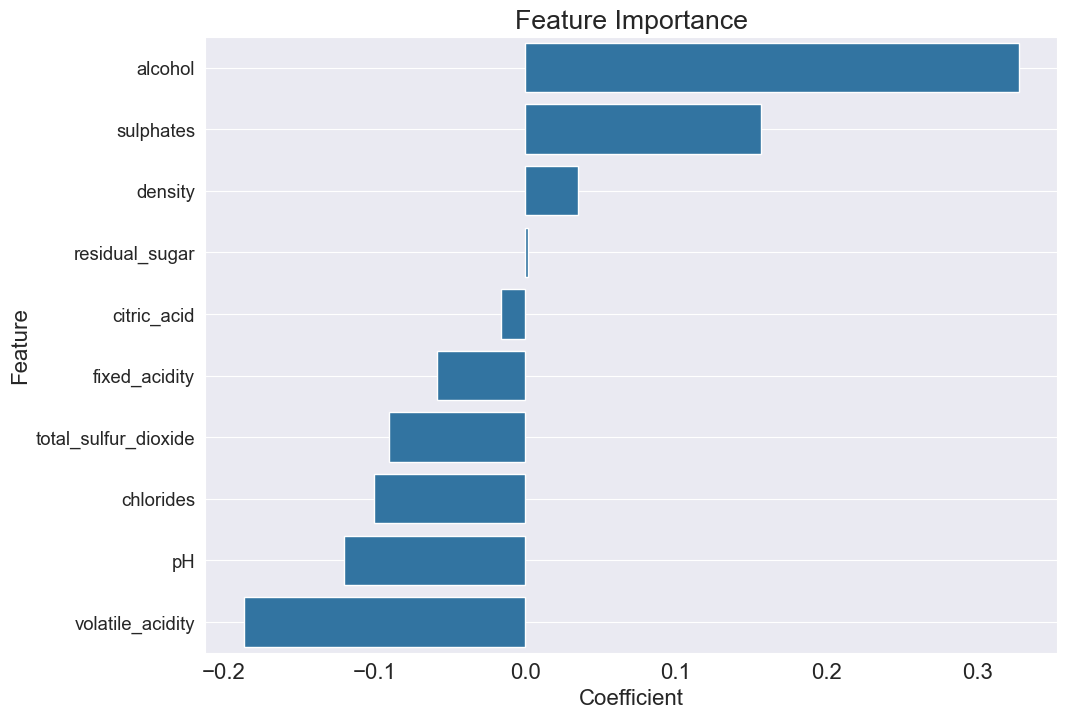

In [25]:
#Feature importance plot for standardized data
plt.figure(figsize=(11, 8))
sns.set_style("darkgrid")
sns.barplot(y="name", x="coeff", data=fi_df)
plt.xlabel("Coefficient")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.grid()
plt.xticks()
plt.yticks(fontsize='small')
plt.show()

## Experiments 

## Recursive Feature Elimination (RFE)

## Pipeline

### Defining functions and pipeline

In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler



# Function to handle outliers
def handle_outliers(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.25)
    quartile3 = dataframe[variable].quantile(0.75)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    dataframe.loc[(dataframe[variable] < low_limit), variable] = round(low_limit, 5)
    dataframe.loc[(dataframe[variable] > up_limit), variable] = round(up_limit, 5)
    return dataframe

# Apply outlier handling to specific columns
def apply_outlier_thresholds(dataframe):
    # Update this list to include only the columns that need outlier treatment
    columns_to_treat = ['citric_acid', 'chlorides', 'total_sulfur_dioxide', 'pH', 'sulphates']
    for col in columns_to_treat:
        dataframe = handle_outliers(dataframe, col)
    return dataframe

# Create a FunctionTransformer to integrate the outlier function into the pipeline
outlier_transformer = FunctionTransformer(apply_outlier_thresholds)

# Define the ColumnTransformer to apply scaling only to the selected features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), selected_features)  # Apply standard scaling to selected features
    ],
    remainder='drop'  # Drop other columns that are not listed in selected_features
)

# Create the preprocessing pipeline with outlier handling and scaling
preprocessing_pipeline = Pipeline(steps=[
    ('outliers', outlier_transformer),  # First step is to apply the outlier_transformer
    ('preprocessor', preprocessor),      # Next, apply the preprocessor defined above
])




NameError: name 'selected_features' is not defined

### Applying pipeline to red_wine to validate the pipeline functions correctly

In [ ]:
# Now apply the pipeline to the DataFrame
# Here we assume red_df is already loaded and contains the column 'quality'
X_red = red_df.drop(['quality'], axis=1)  # Drop the target variable to isolate features
y_red = red_df['quality']                 # Isolate the target variable

# Define the columns we want to keep and preprocess
selected_features = [
    'fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
    'chlorides', 'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol'
]

# Apply the pipeline to the features
red_processed = preprocessing_pipeline.fit_transform(red_df)

# Convert the processed features into a DataFrame
# Note: We need to be careful here because pipeline transformations can return a NumPy array
red_processed_df = pd.DataFrame(red_processed, columns=selected_features)

X_train, X_test, y_train, y_test = train_test_split(red_processed_df, y, random_state=42)

y_red_pred = model.predict(X_test)

X_test

In [ ]:
evaluate_model_performance(y_test, y_red_pred, X_train)

## Testing red wine model on white wine data

In [28]:
# Now apply the pipeline to the DataFrame
# Here we assume red_df is already loaded and contains the column 'quality'
X_white = white_df.drop(['quality'], axis=1)  # Drop the target variable to isolate features
y_white = white_df['quality']                 # Isolate the target variable

# Define the columns we want to keep and preprocess
selected_features = [
    'fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
    'chlorides', 'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol'
]

# Apply the pipeline to the features
X_processed_white = pipeline.fit_transform(X_white)

# Convert the processed features into a DataFrame
# Note: We need to be careful here because pipeline transformations can return a NumPy array
X_processed_df = pd.DataFrame(X_processed_white, columns=selected_features)

y_white_pred = model.predict(X_processed_df)

NameError: name 'pipeline' is not defined

In [29]:
# Example usage:
# Assume y_test, y_pred, and X_train are already defined
evaluate_model_performance(y_white, y_white_pred, X_processed_white)


NameError: name 'y_white_pred' is not defined

### Saving model and preprocessing pipeline

In [ ]:
from joblib import dump

#saving model to our repo
dump(model, 'wine_quality_predictor_model.joblib')

#saving preprocessing pipeline to our repo
dump(preprocessing_pipeline, 'preprocessing_pipeline.joblib')

### CSV export

In [ ]:
residuals_df.to_csv('../data/analysis/winequality_model_residuals.csv',index=False)